In [35]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from transformers import TFBertModel, BertTokenizer
import matplotlib.pyplot as plt

!pip install transformers
!pip install xgboost
!pip install tensorflow

#download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

#load dataset
df = pd.read_csv('fake_job_postings.csv')
print(df.head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo


Percentage of Missing Values:
 job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


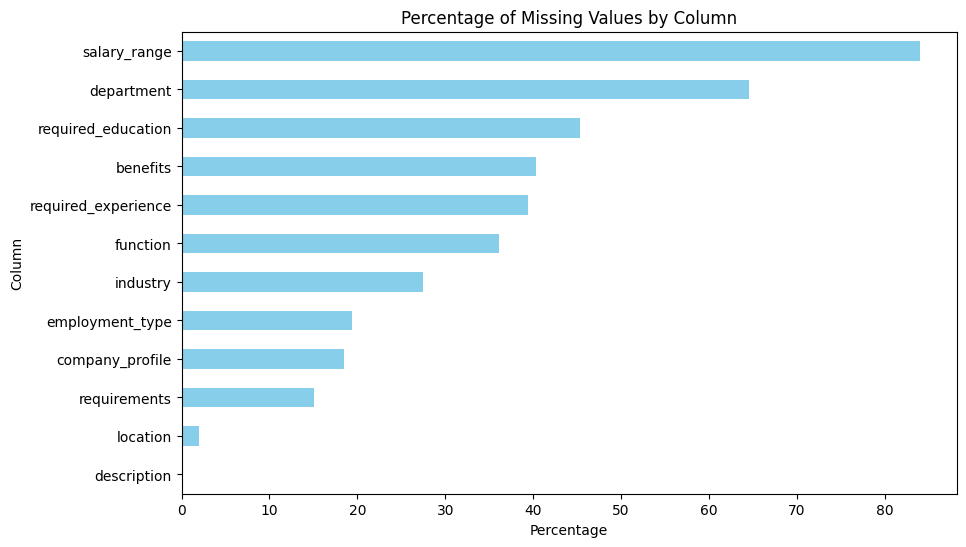

In [36]:
import seaborn as sns
from wordcloud import WordCloud


missing_values = df.isnull().sum() / len(df) * 100
print("\nPercentage of Missing Values:\n", missing_values)

# Plot missing values
plt.figure(figsize=(10, 6))
missing_values[missing_values > 0].sort_values().plot(kind='barh', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Percentage')
plt.ylabel('Column')
plt.show()

<ipython-input-37-946122b3f36a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette='Set2')


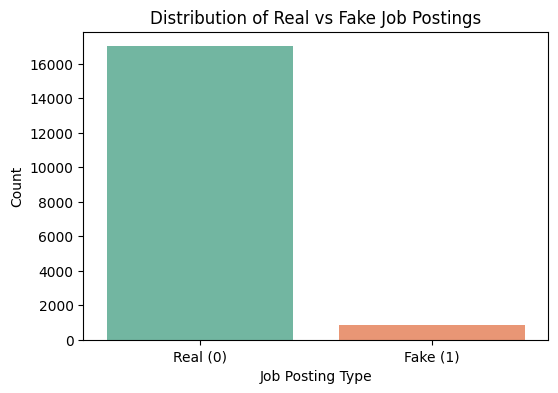


Target Distribution:
 fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64


In [37]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df, palette='Set2')
plt.title('Distribution of Real vs Fake Job Postings')
plt.xticks(ticks=[0, 1], labels=['Real (0)', 'Fake (1)'])
plt.xlabel('Job Posting Type')
plt.ylabel('Count')
plt.show()

# Print the exact counts
print("\nTarget Distribution:\n", df['fraudulent'].value_counts(normalize=True) * 100)

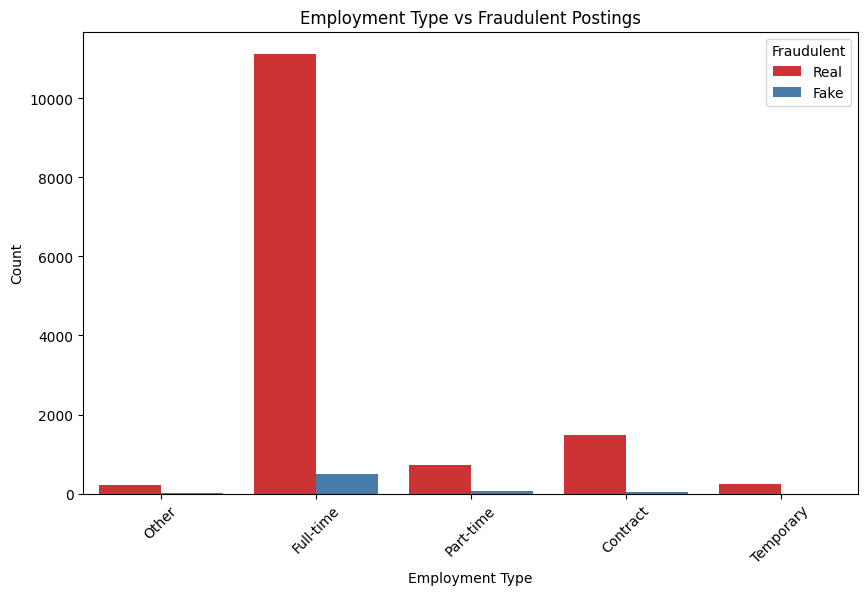

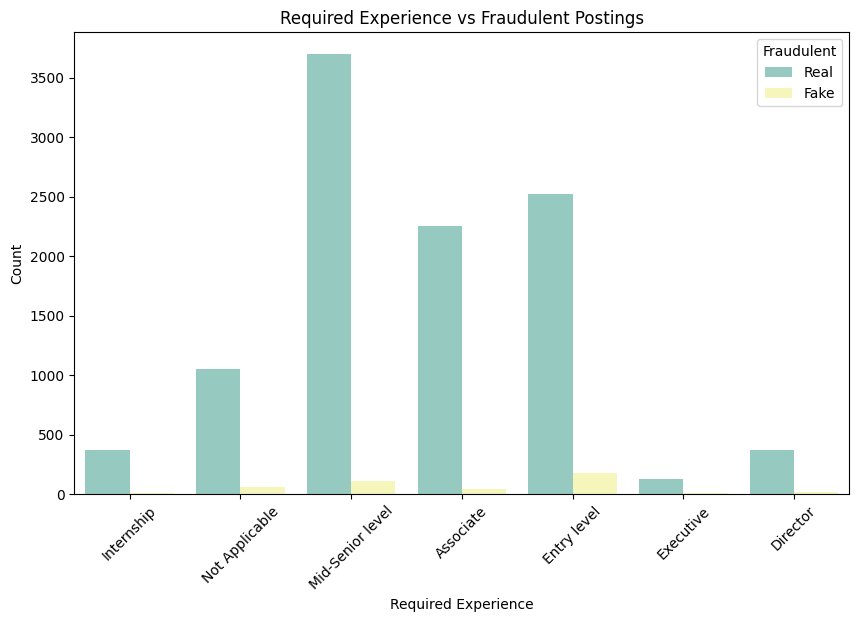

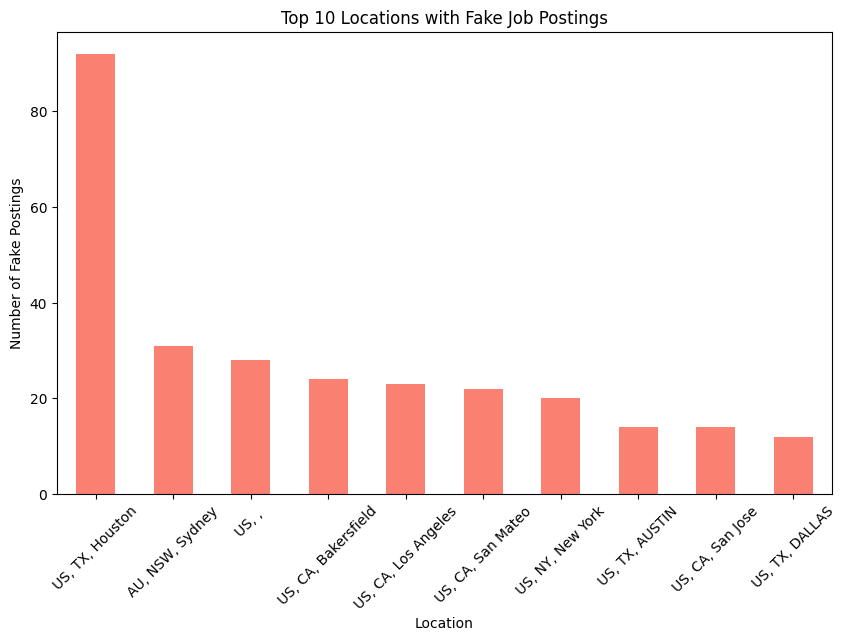

In [38]:
#plot for employment type against fraudulent postings
plt.figure(figsize=(10, 6))
sns.countplot(x='employment_type', hue='fraudulent', data=df, palette='Set1')
plt.title('Employment Type vs Fraudulent Postings')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.show()

#plot for required experience against fraudulent postings
plt.figure(figsize=(10, 6))
sns.countplot(x='required_experience', hue='fraudulent', data=df, palette='Set3')
plt.title('Required Experience vs Fraudulent Postings')
plt.xlabel('Required Experience')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.show()

#plot for top 10 locations for fake job posting
fake_df = df[df['fraudulent'] == 1]
top_locations = fake_df['location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='salmon')
plt.title('Top 10 Locations with Fake Job Postings')
plt.xlabel('Location')
plt.ylabel('Number of Fake Postings')
plt.xticks(rotation=45)
plt.show()

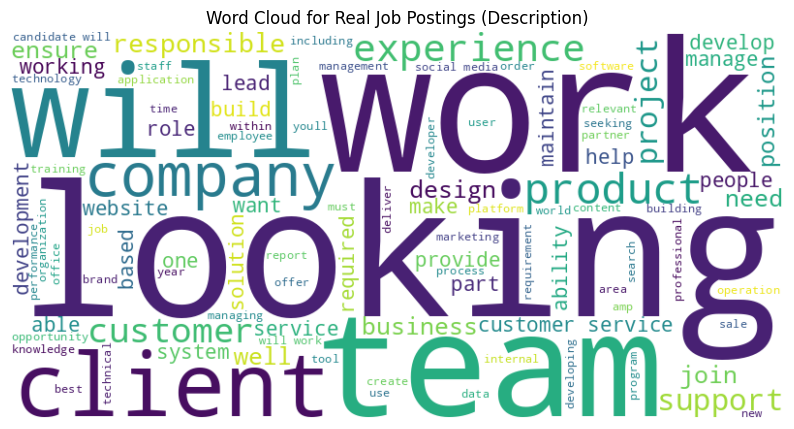

<ipython-input-39-3523ca823d1a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraudulent', y='description_length', data=df, palette='Pastel1')


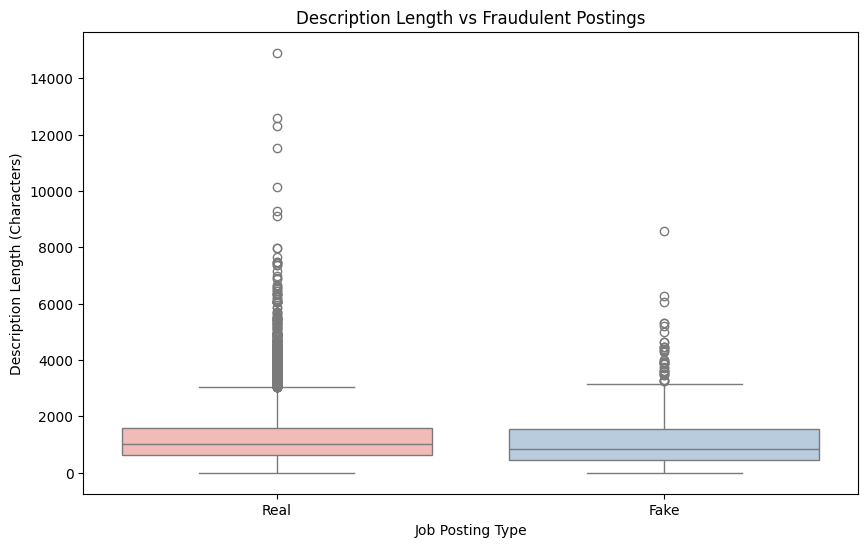

In [39]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    return text

real_text = ' '.join(df[df['fraudulent'] == 0]['description'].apply(clean_text))
fake_text = ' '.join(df[df['fraudulent'] == 1]['description'].apply(clean_text))

#word cloud for real job posting
plt.figure(figsize=(10, 6))
wordcloud_real = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Word Cloud for Real Job Postings (Description)')
plt.axis('off')
plt.show()

#plot for length of description against Fraudulent postings
df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraudulent', y='description_length', data=df, palette='Pastel1')
plt.title('Description Length vs Fraudulent Postings')
plt.xticks(ticks=[0, 1], labels=['Real', 'Fake'])
plt.xlabel('Job Posting Type')
plt.ylabel('Description Length (Characters)')
plt.show()

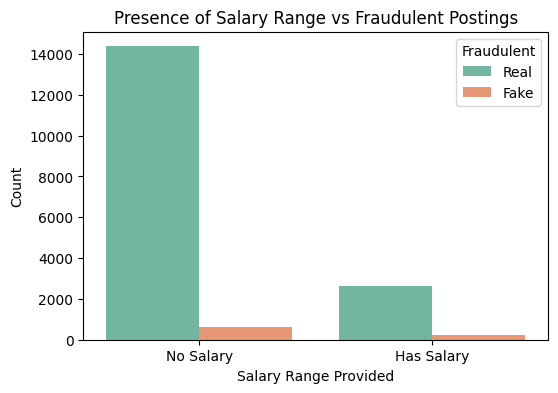

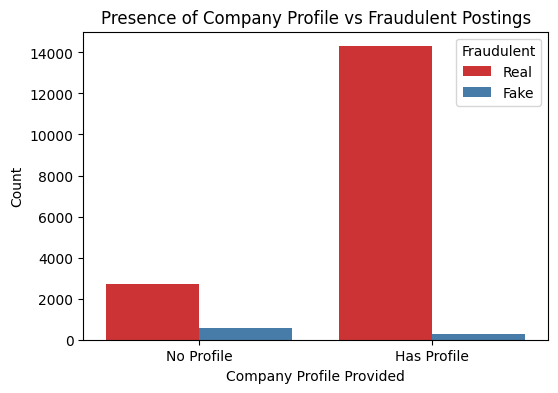

In [40]:
#plot for salary range against fraudulent posting
df['has_salary_range'] = df['salary_range'].notna().astype(int)
plt.figure(figsize=(6, 4))
sns.countplot(x='has_salary_range', hue='fraudulent', data=df, palette='Set2')
plt.title('Presence of Salary Range vs Fraudulent Postings')
plt.xticks(ticks=[0, 1], labels=['No Salary', 'Has Salary'])
plt.xlabel('Salary Range Provided')
plt.ylabel('Count')
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.show()

#plot for company profile against fraudulent posting
df['has_company_profile'] = df['company_profile'].notna().astype(int)
plt.figure(figsize=(6, 4))
sns.countplot(x='has_company_profile', hue='fraudulent', data=df, palette='Set1')
plt.title('Presence of Company Profile vs Fraudulent Postings')
plt.xticks(ticks=[0, 1], labels=['No Profile', 'Has Profile'])
plt.xlabel('Company Profile Provided')
plt.ylabel('Count')
plt.legend(title='Fraudulent', labels=['Real', 'Fake'])
plt.show()

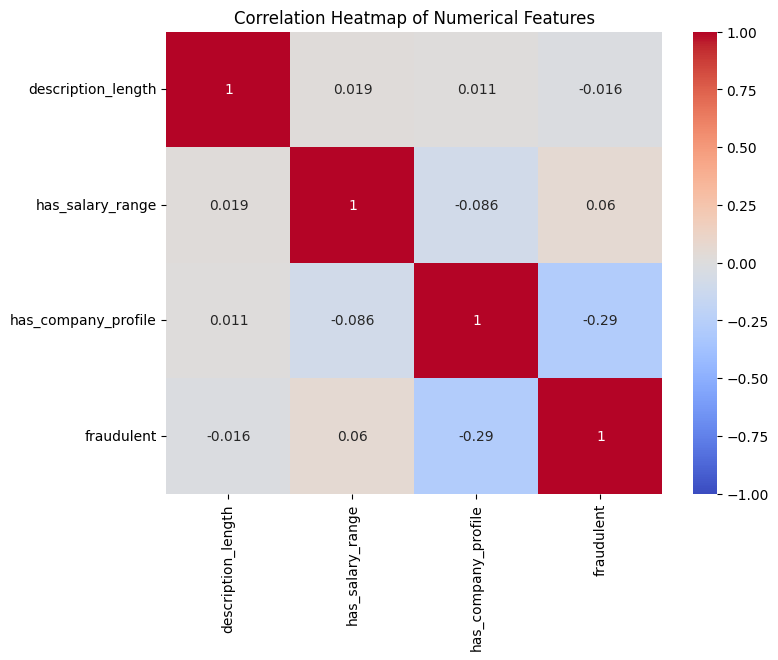

In [41]:
numerical_features = ['description_length', 'has_salary_range', 'has_company_profile', 'fraudulent']
corr_matrix = df[numerical_features].corr()

#correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [49]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#function to preprocess data
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


## LOGISTIC REGRESSION, RANDOM FOREST, and XGBOOST

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

tfidf = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 1))

X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_test_tfidf = tfidf.transform(df_test['text'])

from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=500)
X_train_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = selector.transform(X_test_tfidf)


df_train['suspicious_count_scaled'] = df_train['suspicious_count'] / 10
df_test['suspicious_count_scaled'] = df_test['suspicious_count'] / 10

X_train_features = np.hstack((X_train_selected.toarray(), df_train[['suspicious_count_scaled']].values))
X_test_features = np.hstack((X_test_selected.toarray(), df_test[['suspicious_count_scaled']].values))

#logistic regression
lr = LogisticRegression(
    max_iter=1000,
    C=0.1,
    class_weight='balanced')

lr.fit(X_train_features, y_train)
y_pred_lr = lr.predict(X_test_features)
y_pred_proba_lr = lr.predict_proba(X_test_features)[:, 1]

#random forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced')

rf.fit(X_train_features, y_train)
y_pred_rf = rf.predict(X_test_features)
y_pred_proba_rf = rf.predict_proba(X_test_features)[:, 1]

#XGBoost
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.05,
    reg_alpha=1,
    reg_lambda=2,
    scale_pos_weight=sum(y_train==0)/sum(y_train==1))

xgb_model.fit(X_train_features, y_train)
y_pred_xgb = xgb_model.predict(X_test_features)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_features)[:, 1]

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [43]:
def print_model_results(model_name, y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

print_model_results("Logistic Regression", y_test, y_pred_lr, y_pred_proba_lr)
print_model_results("Random Forest", y_test, y_pred_rf, y_pred_proba_rf)
print_model_results("XGBoost", y_test, y_pred_xgb, y_pred_proba_xgb)


Logistic Regression Results:
Accuracy: 0.8736
Precision: 0.2591
Recall: 0.8671
F1-Score: 0.3989
AUC-ROC: 0.9491

Random Forest Results:
Accuracy: 0.8585
Precision: 0.2386
Recall: 0.8786
F1-Score: 0.3753
AUC-ROC: 0.9409

XGBoost Results:
Accuracy: 0.9032
Precision: 0.3179
Recall: 0.8728
F1-Score: 0.4660
AUC-ROC: 0.9597


## LSTM MODEL

In [44]:
#LSTM
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])

X_train_seq = tokenizer.texts_to_sequences(df_train['text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['text'])

train_seq_lengths = [len(x) for x in X_train_seq]

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(df_train[target_col]), y=df_train[target_col])
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH,
              ),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

history_lstm = lstm_model.fit(
    X_train_pad, df_train[target_col],
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict
)

y_pred_lstm_proba = lstm_model.predict(X_test_pad).ravel()
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print("\nLSTM Results:")
print(f"Accuracy: {accuracy_score(df_test[target_col], y_pred_lstm):.4f}")
print(f"Precision: {precision_score(df_test[target_col], y_pred_lstm, zero_division=0):.4f}")
print(f"Recall: {recall_score(df_test[target_col], y_pred_lstm, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(df_test[target_col], y_pred_lstm, zero_division=0):.4f}")
print(f"AUC-ROC: {roc_auc_score(df_test[target_col], y_pred_lstm_proba):.4f}")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7912 - auc_3: 0.6916 - loss: 1.0188 - precision_3: 0.1114 - recall_3: 0.5083

358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7914 - auc_3: 0.6923 - loss: 1.0174 - precision_3: 0.1117 - recall_3: 0.5092 - val_accuracy: 0.9102 - val_auc_3: 0.9254 - val_loss: 0.4672 - val_precision_3: 0.3144 - val_recall_3: 0.7895
Epoch 2/5
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9299 - auc_3: 0.9663 - loss: 0.3168 - precision_3: 0.4056 - recall_3: 0.9015

358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9299 - auc_3: 0.9663 - loss: 0.3167 - precision_3: 0.4056 - recall_3: 0.9015 - val_accuracy: 0.9479 - val_auc_3: 0.9306 - val_loss: 0.2019 - val_precision_3: 0.4630 - val_recall_3: 0.7519
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9720 - auc_3: 0.9915 - loss: 0.1524 - precision_3: 0.6450 - recall_3: 0.9587 - val_accuracy: 0.9280 - val_auc_3: 0.9279 - val_loss: 0.2374 - val_precision_3: 0.3692 - val_recall_3: 0.7744
Epoch 4/5
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9834 - auc_3: 0.9980 - loss: 0.0790 - precision_3: 0.7500 - recall_3: 0.9891

358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9833 - auc_3: 0.9979 - loss: 0.0790 - precision_3: 0.7498 - recall_3: 0.9891 - val_accuracy: 0.9675 - val_auc_3: 0.9083 - val_loss: 0.1419 - val_precision_3: 0.6538 - val_recall_3: 0.6391
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9829 - auc_3: 0.9977 - loss: 0.0698 - precision_3: 0.7517 - recall_3: 0.9833 - val_accuracy: 0.9525 - val_auc_3: 0.9207 - val_loss: 0.1759 - val_precision_3: 0.4926 - val_recall_3: 0.7519
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

LSTM Results:
Accuracy: 0.9687
Precision: 0.6743
Recall: 0.6821
F1-Score: 0.6782
AUC-ROC: 0.9385


## BERT MODEL

In [46]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df_train[target_col]), y=df_train[target_col])
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    X_train_ids_tf,
    df_train[target_col].values,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict)

y_pred_bert_proba = model.predict(X_test_ids_tf).ravel()
y_pred_bert = (y_pred_bert_proba > 0.5).astype(int)

print("\nBERT-Alternative Results (with class weights):")
print(f"Accuracy: {accuracy_score(df_test[target_col], y_pred_bert):.4f}")
print(f"Precision: {precision_score(df_test[target_col], y_pred_bert, zero_division=0):.4f}")
print(f"Recall: {recall_score(df_test[target_col], y_pred_bert, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(df_test[target_col], y_pred_bert, zero_division=0):.4f}")
print(f"AUC-ROC: {roc_auc_score(df_test[target_col], y_pred_bert_proba):.4f}")

Class weights: {0: np.float64(0.5254573506722504), 1: np.float64(10.32034632034632)}
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5429 - loss: 0.6689 - val_accuracy: 0.8700 - val_loss: 0.3716
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8718 - loss: 0.4004 - val_accuracy: 0.8735 - val_loss: 0.3509
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9391 - loss: 0.2353 - val_accuracy: 0.9542 - val_loss: 0.1645
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9711 - loss: 0.1333 - val_accuracy: 0.9574 - val_loss: 0.1394
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9827 - loss: 0.0740 - val_accuracy: 0.9098 - val_loss: 0.3521
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

BERT-Alternative Results (with class weights):
Accuracy: 0.9153
Precision: 0.3467
Recall: 0.8497
F1-Score: 0.4925
AUC-ROC: 0.9565


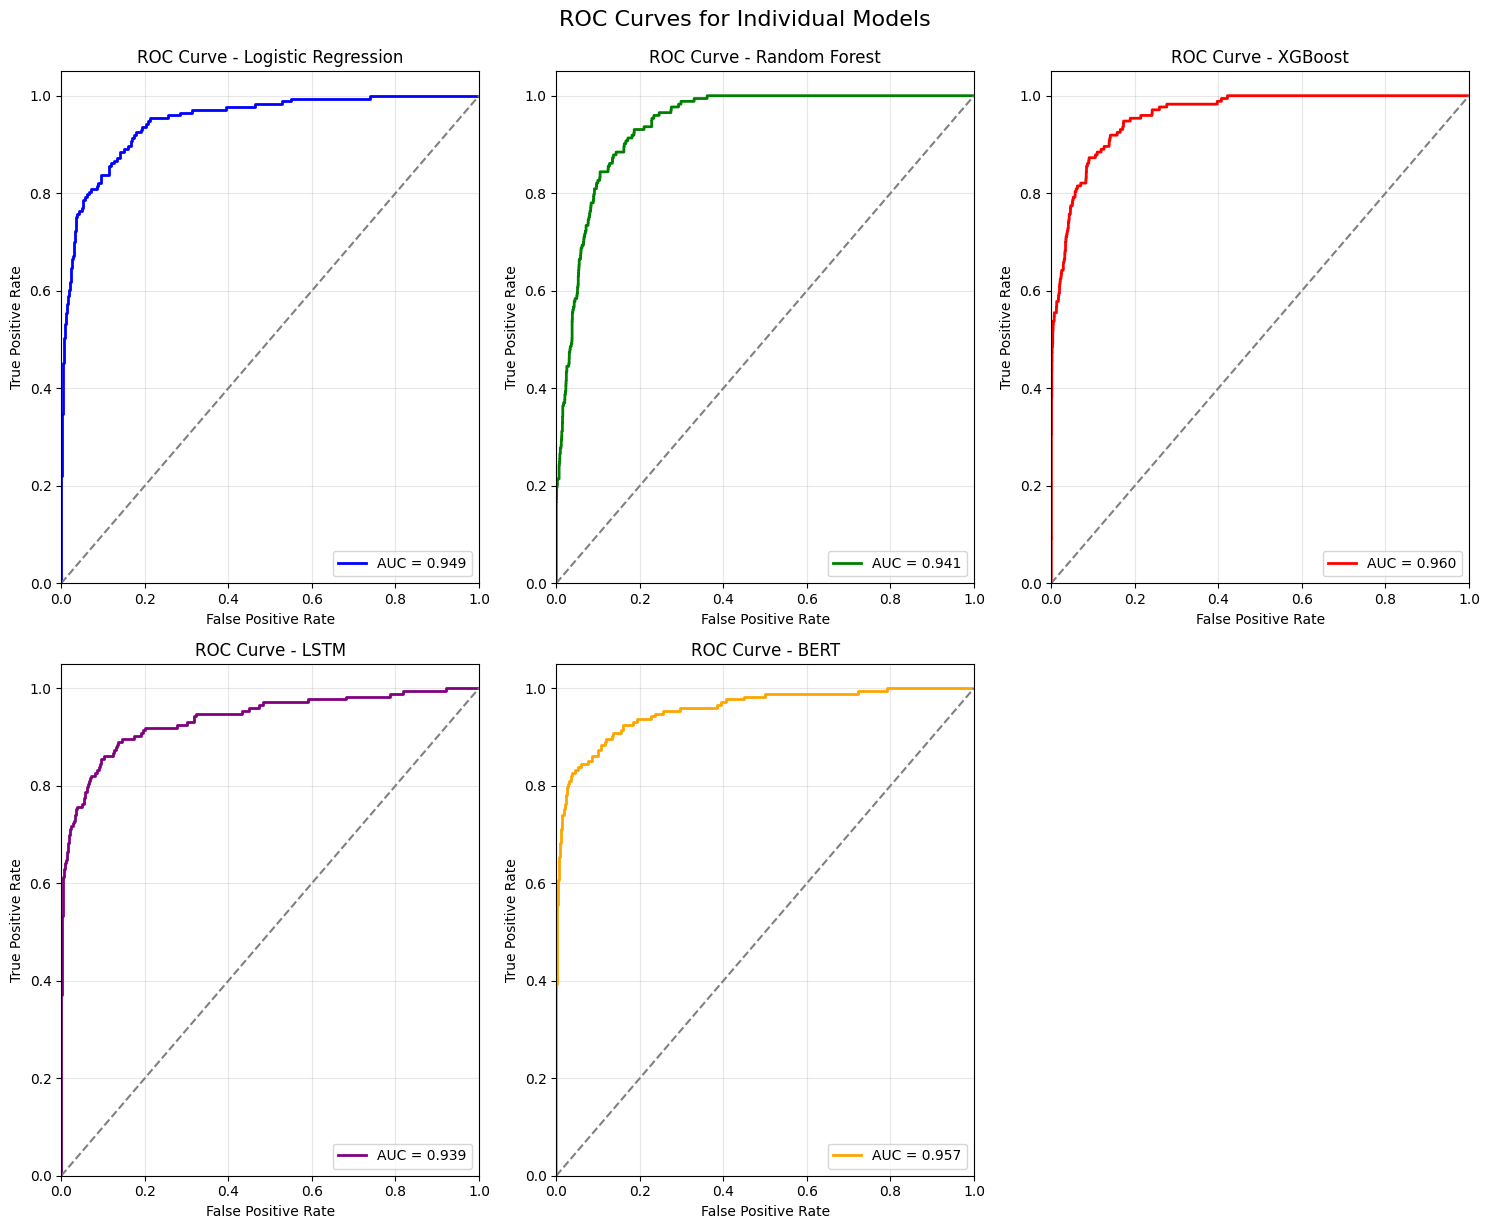

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
fpr_lr, tpr_lr, _ = roc_curve(df_test[target_col], y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'AUC = {roc_auc_lr:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)


plt.subplot(2, 3, 2)
fpr_rf, tpr_rf, _ = roc_curve(df_test[target_col], y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'AUC = {roc_auc_rf:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)


plt.subplot(2, 3, 3)
fpr_xgb, tpr_xgb, _ = roc_curve(df_test[target_col], y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'AUC = {roc_auc_xgb:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)


plt.subplot(2, 3, 4)
fpr_lstm, tpr_lstm, _ = roc_curve(df_test[target_col], y_pred_lstm_proba)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='purple', lw=2, label=f'AUC = {roc_auc_lstm:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)


plt.subplot(2, 3, 5)
fpr_bert, tpr_bert, _ = roc_curve(df_test[target_col], y_pred_bert_proba)
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, color='orange', lw=2, label=f'AUC = {roc_auc_bert:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BERT')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("ROC Curves for Individual Models", fontsize=16, y=1.02)
plt.show()

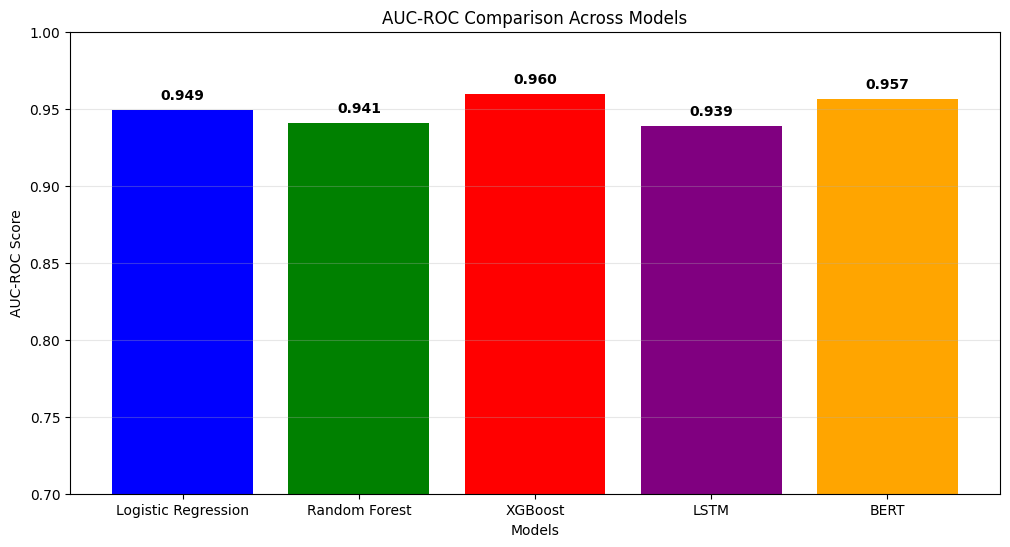

In [48]:
# 2. Plot bar chart of AUC values for easy comparison
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_values = [roc_auc_lr, roc_auc_rf, roc_auc_xgb]

models.append('LSTM')
auc_values.append(roc_auc_lstm)

models.append('BERT')
auc_values.append(roc_auc_bert)

plt.figure(figsize=(12, 6))
bars = plt.bar(models, auc_values, color=['blue', 'green', 'red', 'purple', 'orange'][:len(models)])

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0.70, 1.0)  # Set y-axis to start from 0.7 for better visibility of differences
plt.xlabel('Models')
plt.ylabel('AUC-ROC Score')
plt.title('AUC-ROC Comparison Across Models')
plt.grid(axis='y', alpha=0.3)
plt.show()
